In [ ]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=6f7b8bb6e5850c1937f6d723b233051c95f948e91a399097ba0ed51296d0de9d
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
import yfinance as yf
import pandas_ta as ta
import pandas as pd
import numpy as np


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def compute_indicators(stock_data):
    # Compute ATR
    atr = ta.atr(high=stock_data['High'],
                        low=stock_data['Low'],
                        close=stock_data['Close'],
                        length=14)
    atr_normalized = (atr - atr.mean()) / atr.std()

    # Compute MACD
    macd = ta.macd(close=stock_data['Close'], length=20).iloc[:, 0]
    macd_normalized = (macd - macd.mean()) / macd.std()

    # Compute dollar volume
    dollar_volume = (stock_data['Adj Close'] * stock_data['Volume']) / 1e6

    return atr_normalized, macd_normalized, dollar_volume

In [ ]:
def merge_dataframes(df1, df2):
    # Calculate the difference and percent change for the first dataframe
    df1['Close_Change'] = df1['Close'].diff()
    df1['Close_Percent_Change'] = df1['Close'].pct_change() * 100

    # Save the old column names of the second dataframe
    old_columns = list(df2.columns)

    # Rename the columns of the second dataframe
    df2.columns = ["num", "date", "Question", "Username", "Link", "SubjectParagraph"]

    # Create a new DataFrame with the old columns as the first row
    new_df = pd.DataFrame([old_columns], columns=df2.columns)

    # Concatenate the new DataFrame with the second DataFrame
    df2 = pd.concat([new_df, df2], ignore_index=True)

    # Convert the 'date' column to datetime format and set it as index for the second dataframe
    df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')
    df2.set_index('date', inplace=True)

    df1 = df1.loc[~df1.index.duplicated(keep='first')]
    df2 = df2.loc[~df2.index.duplicated(keep='first')]

    common_dates =df1.index.intersection(df2.index)
    df1_common = df1.loc[common_dates]
    df2_common = df2.loc[common_dates]

    # Merge the two dataframes based on the date index using outer join
    result_df = df1_common.merge(df2_common, left_index=True, right_index=True, how='outer')

    result_df['garman_klass_vol'] = ((np.log(result_df['High']) - np.log(result_df['Low'])) ** 2) / 2 - (2 * np.log(2) - 1) * ((np.log(result_df['Adj Close']) - np.log(result_df['Open'])) ** 2)
    result_df['rsi'] = ta.rsi(close=result_df['Adj Close'], length=14)
    result_df['rsi_standardized'] = (result_df['rsi'] - result_df['rsi'].mean()) / result_df['rsi'].std()
    bbands_df = ta.bbands(close=np.log1p(result_df['Adj Close']), length=20)
    result_df['bb_low'] = bbands_df.iloc[:, 0]
    result_df['bb_mid'] = bbands_df.iloc[:, 1]
    result_df['bb_high'] = bbands_df.iloc[:, 2]

    atr, macd, dollar_volume = compute_indicators(result_df)
    result_df['atr'] = atr
    result_df['macd'] = macd
    result_df['dollar_volume'] = dollar_volume

    return result_df

In [ ]:
# Downloading data for AAPL for the year 2020
dataAAPL = yf.download('AAPL', start='2010-01-01', end='2020-12-31')
dataMSFT = yf.download('MSFT', start='2010-01-01', end='2020-12-31' )
dataNVDA = yf.download('NVDA', start='2010-01-01', end='2020-12-31' )
dataTSLA = yf.download('TSLA', start='2010-01-01', end='2020-12-31' )

# Calculating the daily close change and percentage change
# dataAAPL['Close_Change'] = data['Close'].diff()
# dataAAPL['Close_Percent_Change'] = data['Close'].pct_change() * 100
applestock = pd.read_csv('/content/drive/MyDrive/data/stockapple.csv')
teslastock = pd.read_csv('/content/drive/MyDrive/data/stocktesla.csv')
nvidiastock = pd.read_csv('/content/drive/MyDrive/data/stocknvidia.csv')
microsoftstock = pd.read_csv('/content/drive/MyDrive/data/stockmicrosoft.csv')

resultapple = merge_dataframes(dataAAPL,applestock)
resulttesla = merge_dataframes(dataTSLA,teslastock)
resultnvidia = merge_dataframes(dataNVDA,nvidiastock)
resultmicrosoft = merge_dataframes(dataMSFT,microsoftstock)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
result_df = pd.concat([resultapple, resultmicrosoft,resultnvidia,resultmicrosoft], ignore_index=True)

In [ ]:
result_df = result_df.drop(['num','Question','Username','Link','Close_Change','Adj Close','rsi'],axis =1)

In [ ]:
result_df.shape

(2405, 15)

In [ ]:
result_df.dropna(inplace=True)

In [ ]:
result_df.shape

(2305, 15)

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer
model_path = '/content/drive/MyDrive/Modelsavetransformers/model_save3'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

In [ ]:
def get_model_output(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_number = logits.squeeze().item()
    return predicted_number

In [ ]:
from tqdm import tqdm

output_col = []
for index, row in tqdm(result_df.iterrows(), total=len(result_df)):
    text = row['SubjectParagraph']
    output = get_model_output(text)
    output_col.append(output)


100%|██████████| 2305/2305 [33:58<00:00,  1.13it/s]


In [ ]:
result_df['text_analysis_number'] = output_col

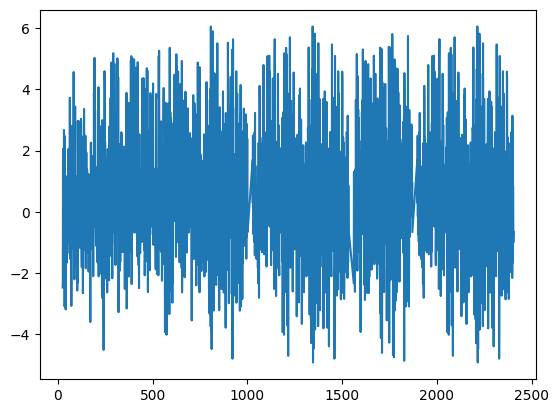

In [ ]:
import matplotlib.pyplot as plt
result_df['text_analysis_number'].plot(kind='line')
plt.show()

In [ ]:
#result_df.to_csv('/content/drive/MyDrive/Modelsavetransformers/Deepfakemodel/preprocessed1.csv')
result_df.to_csv('/content/drive/MyDrive/Modelsavetransformers/Deepfakemodel/Preprocessed1.csv', index=True)


In [ ]:
column_max = result_df['text_analysis_number'].max()
column_min = result_df['text_analysis_number'].min()
print("Maximum value:", column_max)
print("Minimum value:", column_min)

Maximum value: 6.052966117858887
Minimum value: -4.917088508605957
